# Equation Derivation

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

# ============================================================
# HYPERPARAMETERS - Configure these for different datasets
# ============================================================
CSV_FILE = 'lorenz_paper_long.csv'  # Dataset to load
DURATION = 40.0  # Total duration in seconds
DT = 0.01  # Time step used to generate the data
THRESHOLD = 0.23  # Sparsity threshold for SINDy

# Noise parameters
ADD_NOISE = True  # Set to True to add noise, False for clean data
NOISE_LEVEL = 0.05  # Noise standard deviation as fraction of state std
# Common noise levels: 0.0 (clean), 0.01 (1%), 0.05 (5%), 0.1 (10%)

# Quick reference for different datasets:
# - lorenz_paper_short.csv:  DURATION=10.0, DT=0.002
# - lorenz_paper_medium.csv: DURATION=25.0, DT=0.01
# - lorenz_paper_long.csv:   DURATION=40.0, DT=0.01
# - lorenz_original.csv:     DURATION=25.0, DT=0.01

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"Dataset: {CSV_FILE}")
print(f"Duration: {DURATION} seconds")
print(f"Time step (dt): {DT}")
print(f"Threshold: {THRESHOLD}")
print(f"Add Noise: {ADD_NOISE}")
if ADD_NOISE:
    print(f"Noise Level: {NOISE_LEVEL * 100:.1f}% of state standard deviation")
print("="*60)

# Load the Lorenz data
data = pd.read_csv(CSV_FILE)
print("\nData shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nFirst few rows:")
print(data.head())

# Extract state variables
x_clean = data['x'].values
y_clean = data['y'].values
z_clean = data['z'].values

# Add noise if specified
if ADD_NOISE:
    np.random.seed(42)  # For reproducibility

    # Calculate standard deviation of each state variable
    std_x = np.std(x_clean)
    std_y = np.std(y_clean)
    std_z = np.std(z_clean)

    # Generate Gaussian noise scaled by state standard deviation
    noise_x = np.random.normal(0, NOISE_LEVEL * std_x, len(x_clean))
    noise_y = np.random.normal(0, NOISE_LEVEL * std_y, len(y_clean))
    noise_z = np.random.normal(0, NOISE_LEVEL * std_z, len(z_clean))

    # Add noise to clean data
    x = x_clean + noise_x
    y = y_clean + noise_y
    z = z_clean + noise_z

    # Calculate signal-to-noise ratio (SNR)
    snr_x = 20 * np.log10(std_x / np.std(noise_x))
    snr_y = 20 * np.log10(std_y / np.std(noise_y))
    snr_z = 20 * np.log10(std_z / np.std(noise_z))

    print(f"\nNoise Statistics:")
    print(f"  x: std_clean={std_x:.3f}, std_noise={np.std(noise_x):.3f}, SNR={snr_x:.1f} dB")
    print(f"  y: std_clean={std_y:.3f}, std_noise={np.std(noise_y):.3f}, SNR={snr_y:.1f} dB")
    print(f"  z: std_clean={std_z:.3f}, std_noise={np.std(noise_z):.3f}, SNR={snr_z:.1f} dB")
else:
    x = x_clean.copy()
    y = y_clean.copy()
    z = z_clean.copy()
    print("\nNo noise added - using clean data")

n = len(x)

# Generate time array using the specified duration and dt
t = np.linspace(0, DURATION, n)
dt = DT  # Use the hyperparameter dt

print(f"\nNumber of samples: {n}")
print(f"Time step dt: {dt}")
print(f"Expected dt from data: {t[1] - t[0]:.6f}")
if abs(dt - (t[1] - t[0])) > 1e-6:
    print("⚠ WARNING: DT hyperparameter doesn't match the data spacing!")
    print(f"  Consider setting DT = {t[1] - t[0]:.6f}")

# Compute derivatives for all three variables
def compute_derivatives(var, dt):
    """Compute derivatives using finite differences"""
    dvar = np.zeros_like(var)
    dvar[0] = (var[1] - var[0]) / dt
    for i in range(1, len(var)-1):
        dvar[i] = (var[i+1] - var[i-1]) / (2*dt)
    dvar[-1] = (var[-1] - var[-2]) / dt
    return dvar

dx = compute_derivatives(x, dt)
dy = compute_derivatives(y, dt)
dz = compute_derivatives(z, dt)

print("\nDerivative statistics:")
print(f"dx range: [{dx.min():.2f}, {dx.max():.2f}]")
print(f"dy range: [{dy.min():.2f}, {dy.max():.2f}]")
print(f"dz range: [{dz.min():.2f}, {dz.max():.2f}]")

# Build library of candidate functions
library_terms = ["1", "x", "y", "z", "xy", "xz", "yz"]
num_terms = len(library_terms)
Theta = np.zeros((n, num_terms))

Theta[:, 0] = 1
Theta[:, 1] = x
Theta[:, 2] = y
Theta[:, 3] = z
Theta[:, 4] = x * y
Theta[:, 5] = x * z
Theta[:, 6] = y * z

print(f"\nLibrary matrix Theta shape: {Theta.shape}")
print(f"Library terms: {library_terms}")

# Solve for each equation separately
def sparse_regression(Theta, target, threshold):
    """Perform sparse regression with sequential thresholding"""
    xi = np.linalg.lstsq(Theta, target, rcond=None)[0]
    for iteration in range(10):
        small_inds = np.abs(xi) < threshold
        xi[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        xi[big_inds] = np.linalg.lstsq(Theta[:, big_inds], target, rcond=None)[0]
    return xi

# Discover equation for x' (dx/dt)
print("\n" + "="*60)
print("DISCOVERING x' EQUATION")
print("="*60)
xi_x = sparse_regression(Theta, dx, THRESHOLD)
print("\nCoefficients:")
for i, (term, coef) in enumerate(zip(library_terms, xi_x)):
    if coef != 0:
        print(f"  {term}: {coef:.4f}")

equation_x = "x' = "
for i, coef in enumerate(xi_x):
    if coef != 0:
        if coef > 0 and i > 0:
            equation_x += f" + {coef:.4f}*{library_terms[i]}"
        else:
            equation_x += f"{coef:.4f}*{library_terms[i]}"
equation_x = equation_x.replace("+ -", "- ")
print(f"\n{equation_x}")

# Discover equation for y' (dy/dt)
print("\n" + "="*60)
print("DISCOVERING y' EQUATION")
print("="*60)
xi_y = sparse_regression(Theta, dy, THRESHOLD)
print("\nCoefficients:")
for i, (term, coef) in enumerate(zip(library_terms, xi_y)):
    if coef != 0:
        print(f"  {term}: {coef:.4f}")

equation_y = "y' = "
for i, coef in enumerate(xi_y):
    if coef != 0:
        if coef > 0 and i > 0:
            equation_y += f" + {coef:.4f}*{library_terms[i]}"
        else:
            equation_y += f"{coef:.4f}*{library_terms[i]}"
equation_y = equation_y.replace("+ -", "- ")
print(f"\n{equation_y}")

# Discover equation for z' (dz/dt)
print("\n" + "="*60)
print("DISCOVERING z' EQUATION")
print("="*60)
xi_z = sparse_regression(Theta, dz, THRESHOLD)
print("\nCoefficients:")
for i, (term, coef) in enumerate(zip(library_terms, xi_z)):
    if coef != 0:
        print(f"  {term}: {coef:.4f}")

equation_z = "z' = "
for i, coef in enumerate(xi_z):
    if coef != 0:
        if coef > 0 and i > 0:
            equation_z += f" + {coef:.4f}*{library_terms[i]}"
        else:
            equation_z += f"{coef:.4f}*{library_terms[i]}"
equation_z = equation_z.replace("+ -", "- ")
print(f"\n{equation_z}")

# Calculate errors
dx_pred = Theta @ xi_x
dy_pred = Theta @ xi_y
dz_pred = Theta @ xi_z

mse_x = np.mean((dx - dx_pred)**2)
mse_y = np.mean((dy - dy_pred)**2)
mse_z = np.mean((dz - dz_pred)**2)

print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"MSE for x': {mse_x:.6e}")
print(f"MSE for y': {mse_y:.6e}")
print(f"MSE for z': {mse_z:.6e}")
print(f"Overall MSE: {(mse_x + mse_y + mse_z)/3:.6e}")

print("\n" + "="*60)
print("DISCOVERED SYSTEM")
print("="*60)
print(equation_x)
print(equation_y)
print(equation_z)

print("\n" + "="*60)
print("TRUE LORENZ SYSTEM (for comparison)")
print("="*60)
print("x' = -10.0*x + 10.0*y")
print("y' = 28.0*x - 1.0*y - 1.0*xz")
print("z' = -2.67*z + 1.0*xy")


CONFIGURATION
Dataset: lorenz_paper_long.csv
Duration: 40.0 seconds
Time step (dt): 0.01
Threshold: 0.23
Add Noise: True
Noise Level: 5.0% of state standard deviation

Data shape: (4001, 3)
Columns: ['x', 'y', 'z']

First few rows:
          x         y          z
0 -8.000000  8.000000  27.000000
1 -6.486403  7.803171  25.725523
2 -5.138018  7.562589  24.608811
3 -3.941506  7.312988  23.628928
4 -2.882048  7.078172  22.765711

Noise Statistics:
  x: std_clean=7.734, std_noise=0.386, SNR=26.0 dB
  y: std_clean=8.760, std_noise=0.445, SNR=25.9 dB
  z: std_clean=8.373, std_noise=0.415, SNR=26.1 dB

Number of samples: 4001
Time step dt: 0.01
Expected dt from data: 0.010000

Derivative statistics:
dx range: [-172.20, 174.06]
dy range: [-346.68, 304.27]
dz range: [-179.65, 342.91]

Library matrix Theta shape: (4001, 7)
Library terms: ['1', 'x', 'y', 'z', 'xy', 'xz', 'yz']

DISCOVERING x' EQUATION

Coefficients:
  x: -9.7522
  y: 9.7685

x' = -9.7522*x + 9.7685*y

DISCOVERING y' EQUATION

Coe

# Visualization

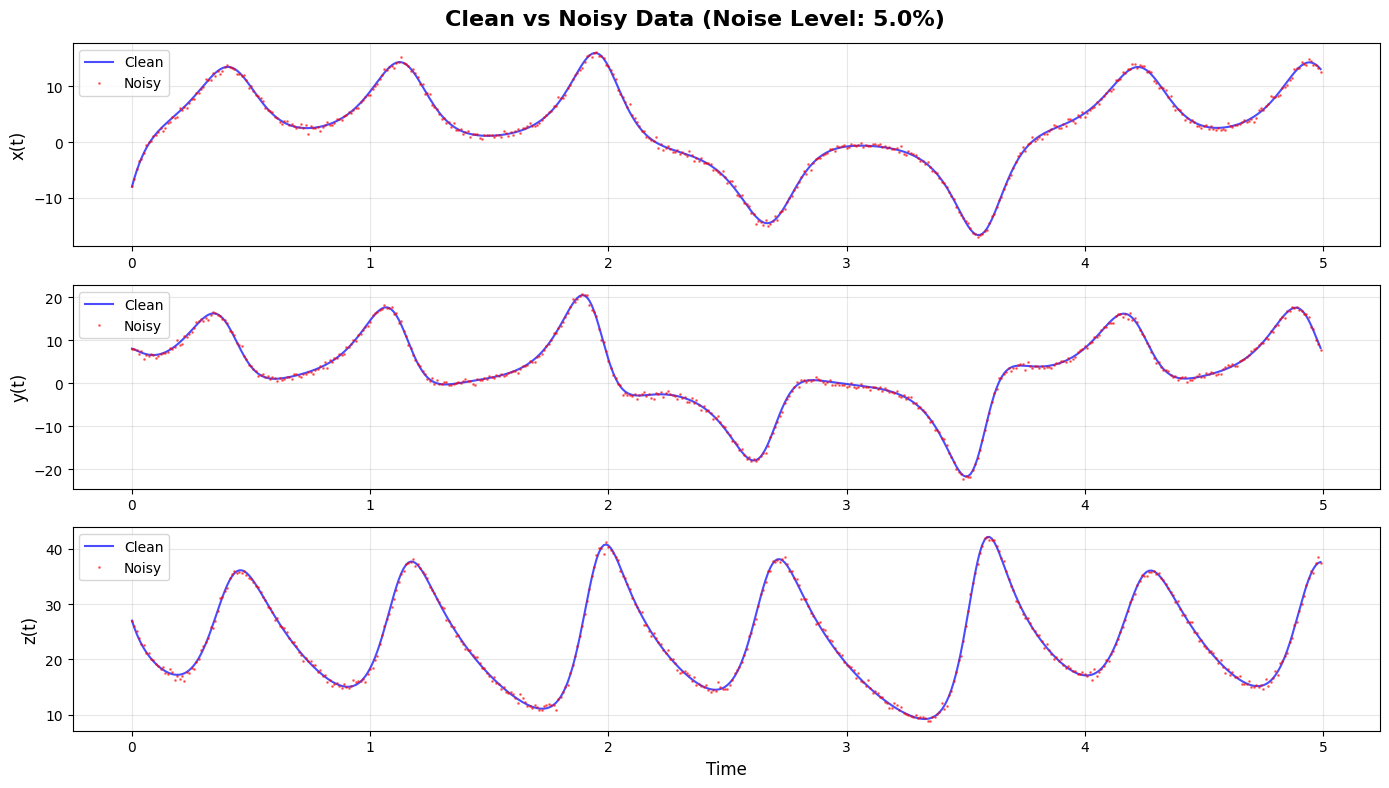

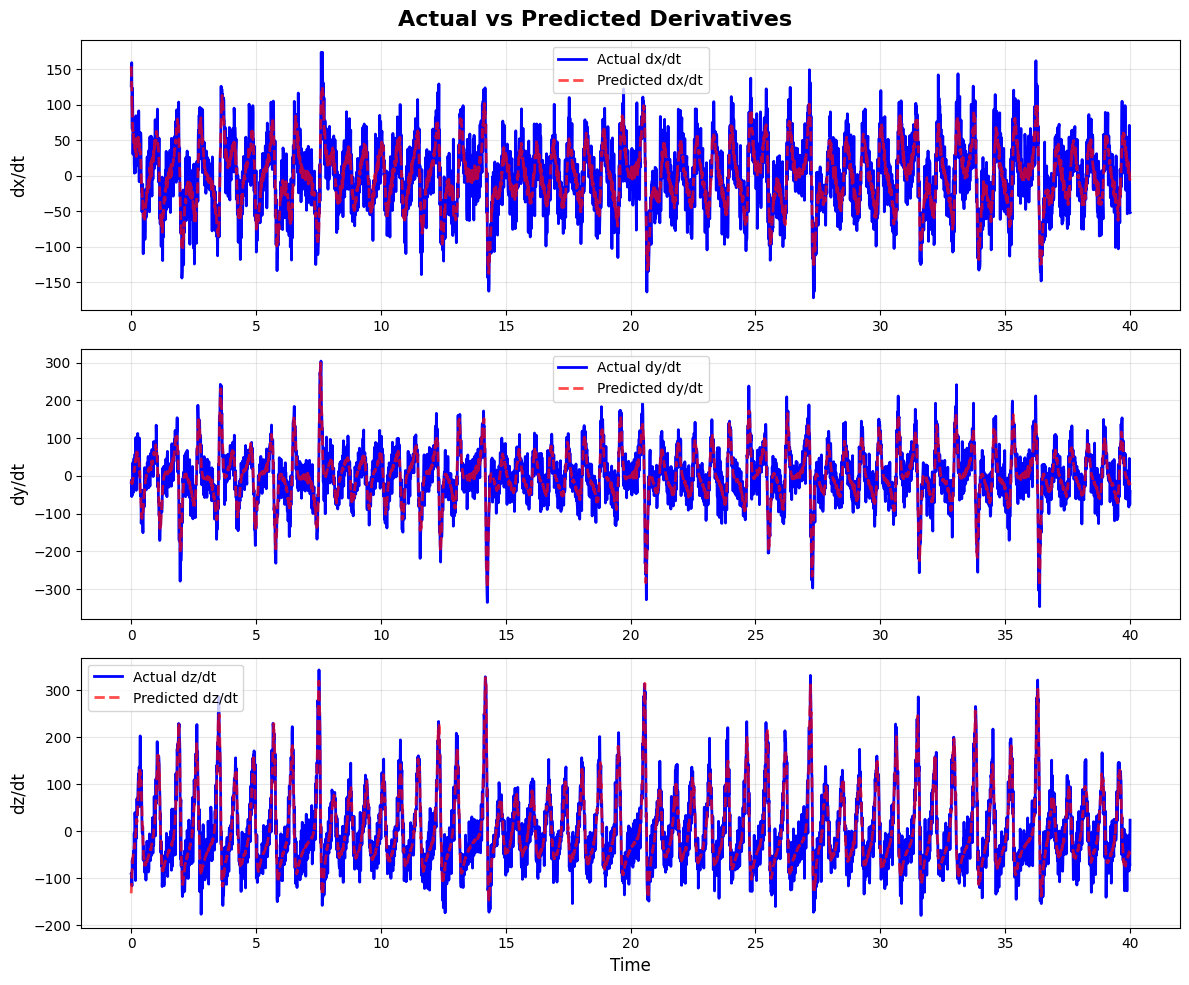

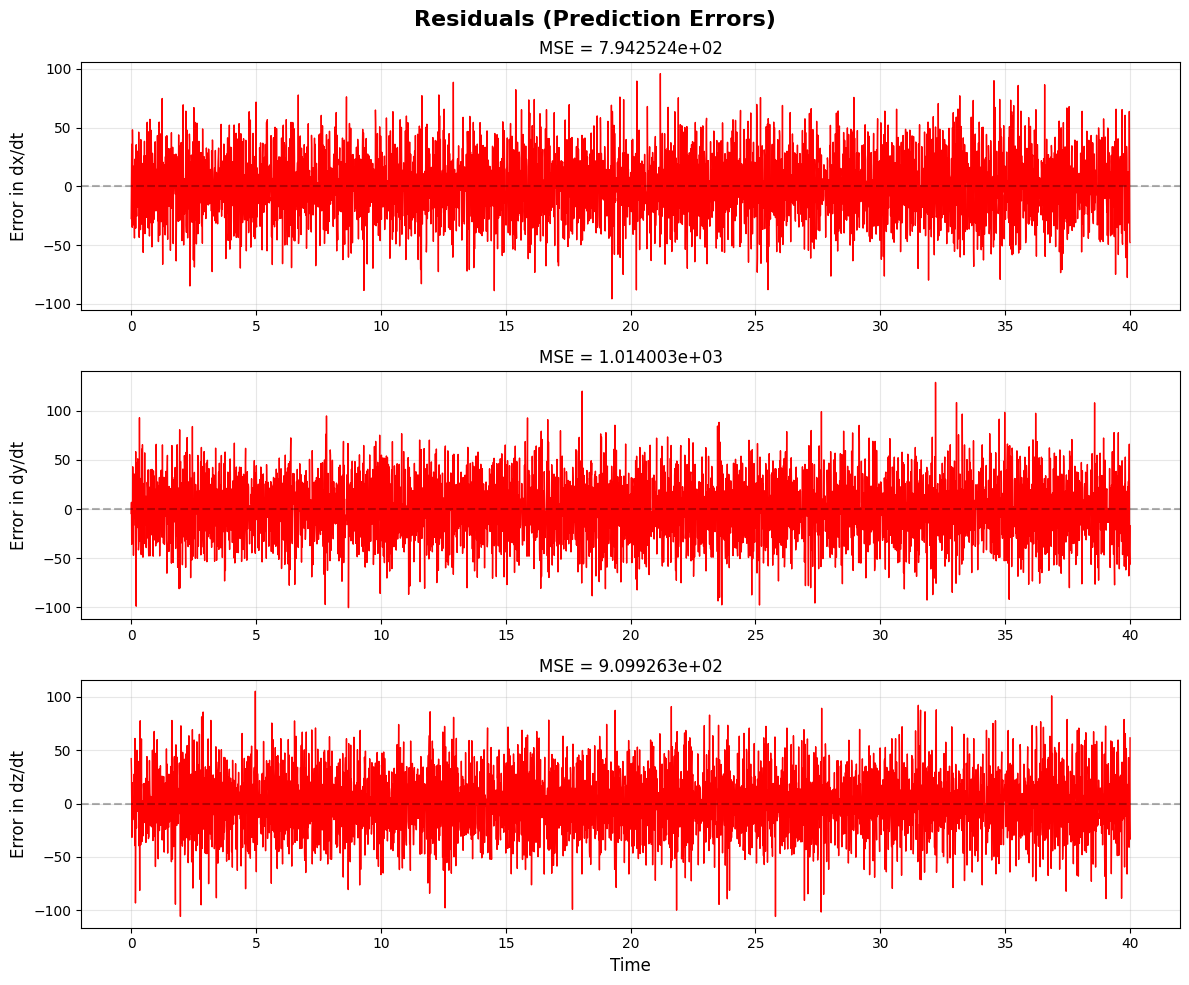

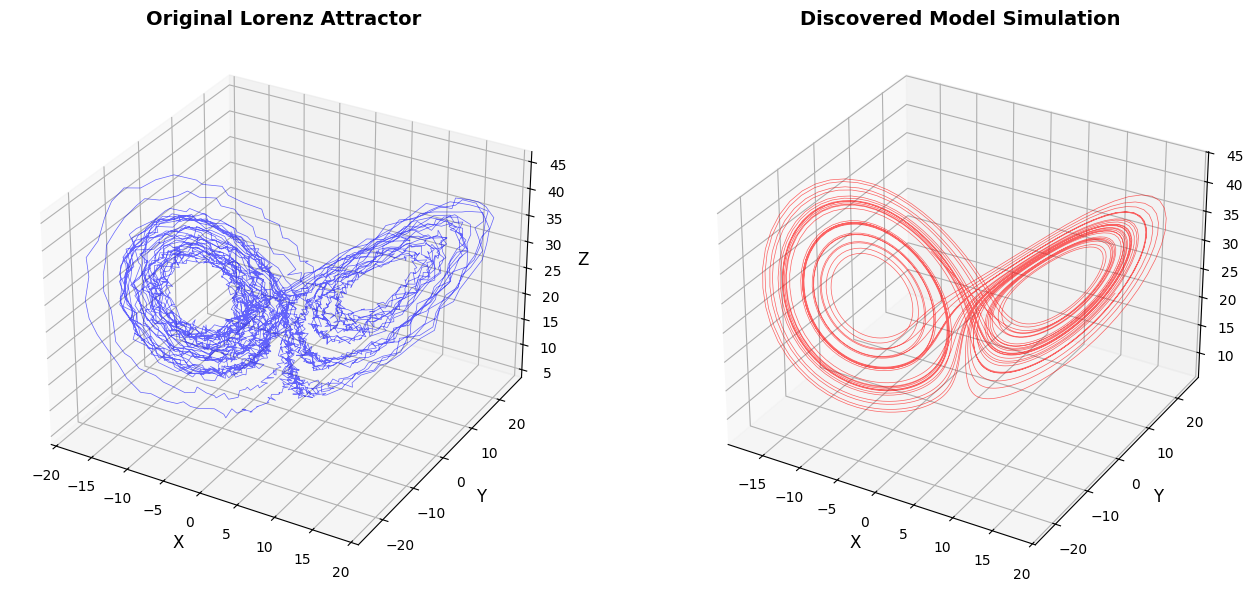

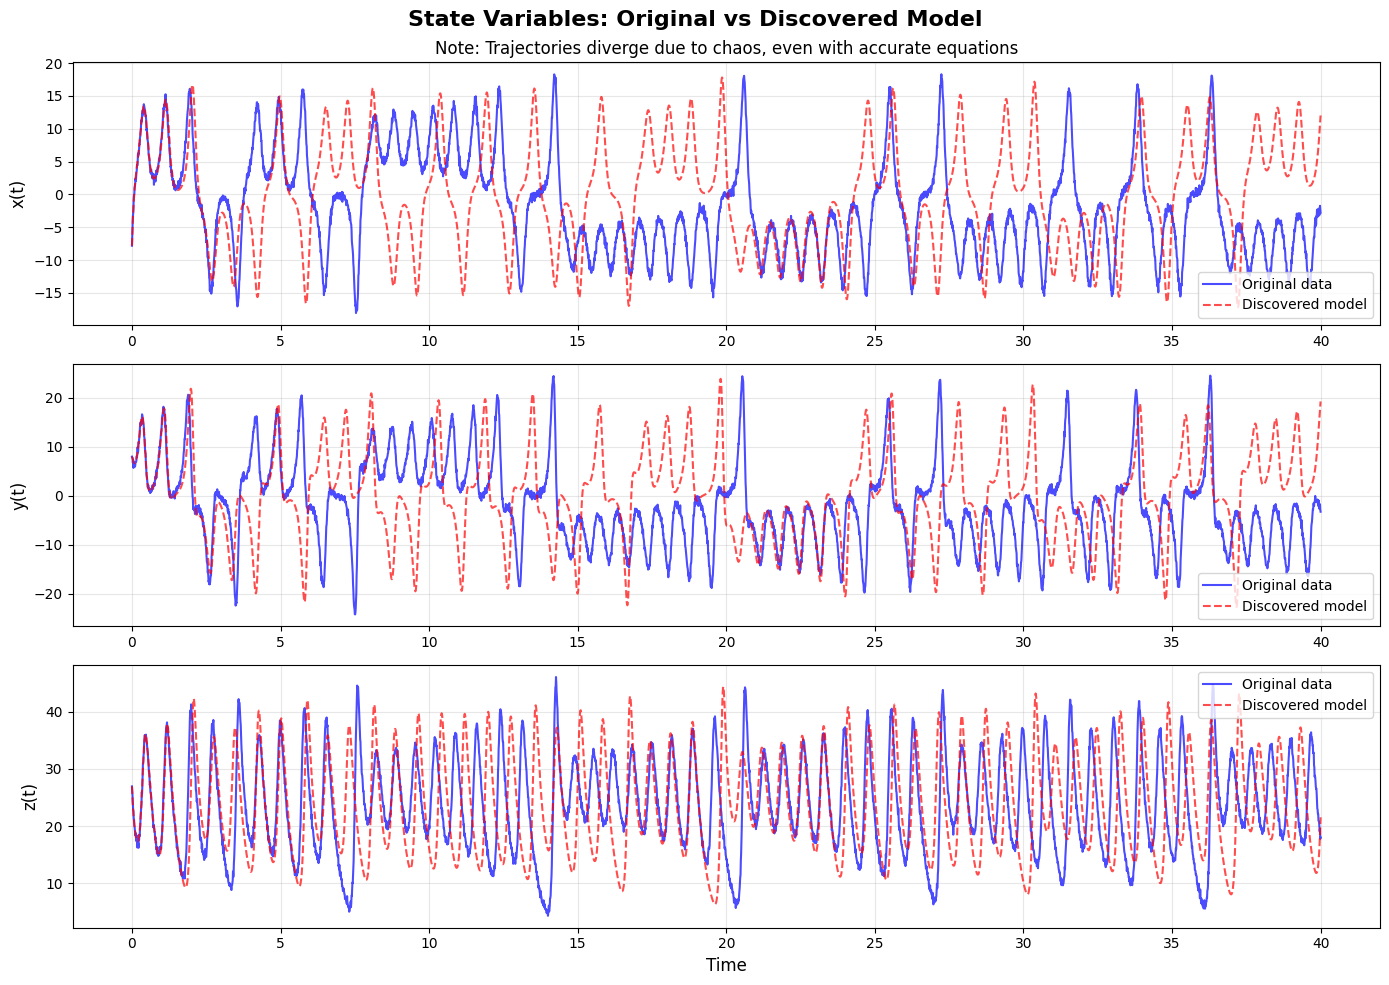

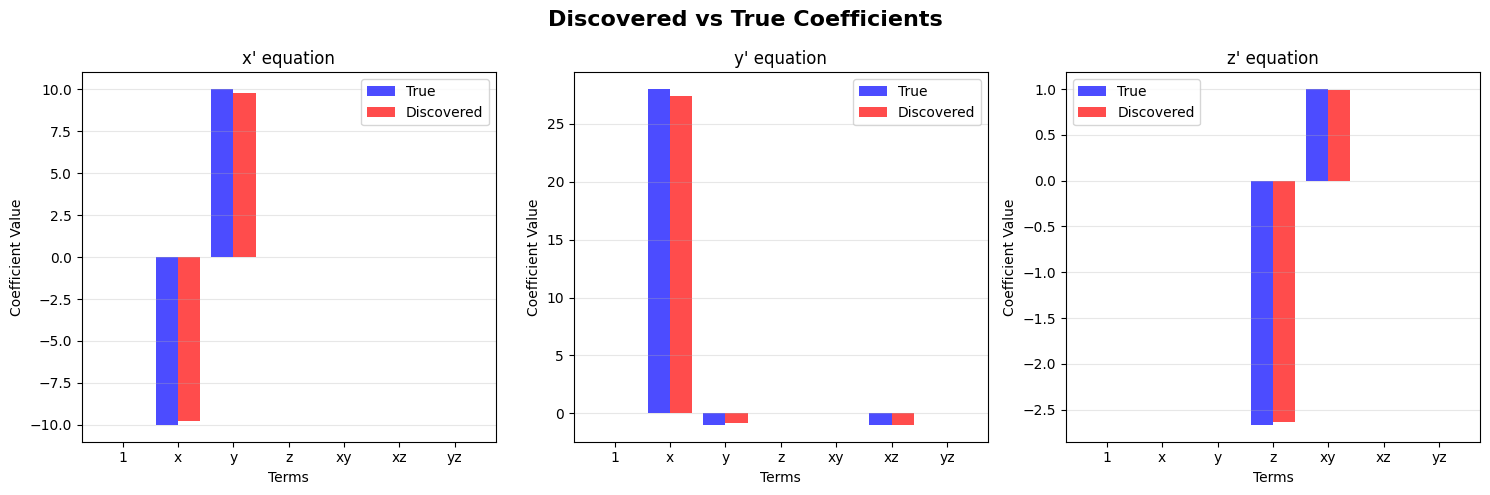


COEFFICIENT ACCURACY
x' equation: -10 vs -9.7522 (x term), 10 vs 9.7685 (y term)
   Accuracy: 97.52%, 97.69%

y' equation: 28 vs 27.3942 (x), -1 vs -0.8221 (y), -1 vs -0.9863 (xz)
   Accuracy: 97.84%, 82.21%, 98.63%

z' equation: -2.67 vs -2.6345 (z), 1 vs 0.9868 (xy)
   Accuracy: 98.80%, 98.68%

VISUALIZATION COMPLETE
Generated plots:
1. Actual vs Predicted Derivatives
2. Residual Errors
3. 3D Phase Space (Original vs Discovered)
4. Time Series Comparison - Shows trajectory divergence due to chaos
5. Coefficient Comparison - Bar charts showing accuracy


In [17]:
# ============================================================
# VISUALIZATION
# ============================================================

# 0. If noise was added, show clean vs noisy data comparison
if ADD_NOISE:
    fig, axes = plt.subplots(3, 1, figsize=(14, 8))
    fig.suptitle(f'Clean vs Noisy Data (Noise Level: {NOISE_LEVEL*100:.1f}%)',
                 fontsize=16, fontweight='bold')

    time_window = slice(0, min(500, n))  # Show first 500 points or less

    axes[0].plot(t[time_window], x_clean[time_window], 'b-', label='Clean', linewidth=1.5, alpha=0.7)
    axes[0].plot(t[time_window], x[time_window], 'r.', label='Noisy', markersize=2, alpha=0.5)
    axes[0].set_ylabel('x(t)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(t[time_window], y_clean[time_window], 'b-', label='Clean', linewidth=1.5, alpha=0.7)
    axes[1].plot(t[time_window], y[time_window], 'r.', label='Noisy', markersize=2, alpha=0.5)
    axes[1].set_ylabel('y(t)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(t[time_window], z_clean[time_window], 'b-', label='Clean', linewidth=1.5, alpha=0.7)
    axes[2].plot(t[time_window], z[time_window], 'r.', label='Noisy', markersize=2, alpha=0.5)
    axes[2].set_xlabel('Time', fontsize=12)
    axes[2].set_ylabel('z(t)', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 1. Compare actual vs predicted derivatives
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Actual vs Predicted Derivatives', fontsize=16, fontweight='bold')

axes[0].plot(t, dx, 'b-', label='Actual dx/dt', linewidth=2)
axes[0].plot(t, dx_pred, 'r--', label='Predicted dx/dt', linewidth=2, alpha=0.7)
axes[0].set_ylabel("dx/dt", fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, dy, 'b-', label='Actual dy/dt', linewidth=2)
axes[1].plot(t, dy_pred, 'r--', label='Predicted dy/dt', linewidth=2, alpha=0.7)
axes[1].set_ylabel("dy/dt", fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(t, dz, 'b-', label='Actual dz/dt', linewidth=2)
axes[2].plot(t, dz_pred, 'r--', label='Predicted dz/dt', linewidth=2, alpha=0.7)
axes[2].set_xlabel("Time", fontsize=12)
axes[2].set_ylabel("dz/dt", fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Residual plots (errors)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Residuals (Prediction Errors)', fontsize=16, fontweight='bold')

error_x = dx - dx_pred
error_y = dy - dy_pred
error_z = dz - dz_pred

axes[0].plot(t, error_x, 'r-', linewidth=1)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].set_ylabel("Error in dx/dt", fontsize=12)
axes[0].set_title(f"MSE = {mse_x:.6e}")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, error_y, 'r-', linewidth=1)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].set_ylabel("Error in dy/dt", fontsize=12)
axes[1].set_title(f"MSE = {mse_y:.6e}")
axes[1].grid(True, alpha=0.3)

axes[2].plot(t, error_z, 'r-', linewidth=1)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[2].set_xlabel("Time", fontsize=12)
axes[2].set_ylabel("Error in dz/dt", fontsize=12)
axes[2].set_title(f"MSE = {mse_z:.6e}")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 3D Phase space plot
fig = plt.figure(figsize=(14, 6))

# Original trajectory
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x, y, z, 'b-', linewidth=0.5, alpha=0.6)
ax1.set_xlabel('X', fontsize=12)
ax1.set_ylabel('Y', fontsize=12)
ax1.set_zlabel('Z', fontsize=12)
ax1.set_title('Original Lorenz Attractor', fontsize=14, fontweight='bold')

# Simulate using discovered equations
def discovered_lorenz(t, X, xi_x, xi_y, xi_z, library_terms):
    """Use discovered equations to simulate"""
    x, y, z = X
    theta_point = np.array([1, x, y, z, x*y, x*z, y*z])
    dxdt = theta_point @ xi_x
    dydt = theta_point @ xi_y
    dzdt = theta_point @ xi_z
    return [dxdt, dydt, dzdt]

# Simulate using discovered model (same duration as data)
X0_sim = [x[0], y[0], z[0]]
t_sim = np.linspace(0, DURATION, n)

sol_discovered = solve_ivp(
    lambda t, X: discovered_lorenz(t, X, xi_x, xi_y, xi_z, library_terms),
    [t_sim[0], t_sim[-1]],
    X0_sim,
    t_eval=t_sim,
    method='RK45'
)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(sol_discovered.y[0], sol_discovered.y[1], sol_discovered.y[2],
         'r-', linewidth=0.5, alpha=0.6)
ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Y', fontsize=12)
ax2.set_zlabel('Z', fontsize=12)
ax2.set_title('Discovered Model Simulation', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Time series comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('State Variables: Original vs Discovered Model', fontsize=16, fontweight='bold')

axes[0].plot(t, x, 'b-', label='Original data', linewidth=1.5, alpha=0.7)
axes[0].plot(t_sim, sol_discovered.y[0], 'r--', label='Discovered model', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('x(t)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Note: Trajectories diverge due to chaos, even with accurate equations')

axes[1].plot(t, y, 'b-', label='Original data', linewidth=1.5, alpha=0.7)
axes[1].plot(t_sim, sol_discovered.y[1], 'r--', label='Discovered model', linewidth=1.5, alpha=0.7)
axes[1].set_ylabel('y(t)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(t, z, 'b-', label='Original data', linewidth=1.5, alpha=0.7)
axes[2].plot(t_sim, sol_discovered.y[2], 'r--', label='Discovered model', linewidth=1.5, alpha=0.7)
axes[2].set_xlabel('Time', fontsize=12)
axes[2].set_ylabel('z(t)', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Coefficient comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Discovered vs True Coefficients', fontsize=16, fontweight='bold')

# True coefficients
true_x = np.array([0, -10, 10, 0, 0, 0, 0])
true_y = np.array([0, 28, -1, 0, 0, -1, 0])
true_z = np.array([0, 0, 0, -8/3, 1, 0, 0])

terms_labels = ["1", "x", "y", "z", "xy", "xz", "yz"]
x_pos = np.arange(len(terms_labels))

# X' equation
axes[0].bar(x_pos - 0.2, true_x, 0.4, label='True', alpha=0.7, color='blue')
axes[0].bar(x_pos + 0.2, xi_x, 0.4, label='Discovered', alpha=0.7, color='red')
axes[0].set_xlabel('Terms')
axes[0].set_ylabel('Coefficient Value')
axes[0].set_title("x' equation")
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(terms_labels)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Y' equation
axes[1].bar(x_pos - 0.2, true_y, 0.4, label='True', alpha=0.7, color='blue')
axes[1].bar(x_pos + 0.2, xi_y, 0.4, label='Discovered', alpha=0.7, color='red')
axes[1].set_xlabel('Terms')
axes[1].set_ylabel('Coefficient Value')
axes[1].set_title("y' equation")
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(terms_labels)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Z' equation
axes[2].bar(x_pos - 0.2, true_z, 0.4, label='True', alpha=0.7, color='blue')
axes[2].bar(x_pos + 0.2, xi_z, 0.4, label='Discovered', alpha=0.7, color='red')
axes[2].set_xlabel('Terms')
axes[2].set_ylabel('Coefficient Value')
axes[2].set_title("z' equation")
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(terms_labels)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("COEFFICIENT ACCURACY")
print("="*60)
print(f"x' equation: -10 vs {xi_x[1]:.4f} (x term), 10 vs {xi_x[2]:.4f} (y term)")
print(f"   Accuracy: {100*(1-abs(xi_x[1]+10)/10):.2f}%, {100*(1-abs(xi_x[2]-10)/10):.2f}%")
print(f"\ny' equation: 28 vs {xi_y[1]:.4f} (x), -1 vs {xi_y[2]:.4f} (y), -1 vs {xi_y[5]:.4f} (xz)")
print(f"   Accuracy: {100*(1-abs(xi_y[1]-28)/28):.2f}%, {100*(1-abs(xi_y[2]+1)/1):.2f}%, {100*(1-abs(xi_y[5]+1)/1):.2f}%")
print(f"\nz' equation: -2.67 vs {xi_z[3]:.4f} (z), 1 vs {xi_z[4]:.4f} (xy)")
print(f"   Accuracy: {100*(1-abs(xi_z[3]+8/3)/(8/3)):.2f}%, {100*(1-abs(xi_z[4]-1)/1):.2f}%")

print("\n" + "="*60)
print("VISUALIZATION COMPLETE")
print("="*60)
print("Generated plots:")
print("1. Actual vs Predicted Derivatives")
print("2. Residual Errors")
print("3. 3D Phase Space (Original vs Discovered)")
print("4. Time Series Comparison - Shows trajectory divergence due to chaos")
print("5. Coefficient Comparison - Bar charts showing accuracy")